In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512) 
        self.fc0 = nn.Linear(512, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [2]:
#torch.manual_seed(7)

In [3]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58043/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58043/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [4]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58043/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58043/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [5]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [6]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    # for i in range(len(lay)):
    #     if i > 0 and i <= len(lay)-1:
    #         di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


  0%|          | 0/235 [00:00<?, ?it/s]

100%|██████████| 235/235 [00:01<00:00, 172.67it/s]


Epoch 0/100, Loss: 0.00816934835165739, train dataset accuracy: 77.195
test dataset accuracy: 92.24%


100%|██████████| 235/235 [00:01<00:00, 187.80it/s]


Epoch 1/100, Loss: 0.00916080828756094, train dataset accuracy: 92.67666666666666
test dataset accuracy: 93.14%


100%|██████████| 235/235 [00:01<00:00, 187.60it/s]


Epoch 2/100, Loss: 0.01244414784014225, train dataset accuracy: 93.54166666666667
test dataset accuracy: 93.6%


100%|██████████| 235/235 [00:01<00:00, 170.08it/s]


Epoch 3/100, Loss: 0.010629257187247276, train dataset accuracy: 94.01166666666667
test dataset accuracy: 93.72%


100%|██████████| 235/235 [00:01<00:00, 188.16it/s]


Epoch 4/100, Loss: 0.012255226261913776, train dataset accuracy: 94.27333333333333
test dataset accuracy: 94.29%


100%|██████████| 235/235 [00:01<00:00, 182.83it/s]


Epoch 5/100, Loss: 0.004240977577865124, train dataset accuracy: 94.60333333333334
test dataset accuracy: 94.23%


100%|██████████| 235/235 [00:01<00:00, 190.12it/s]


Epoch 6/100, Loss: 0.005943273659795523, train dataset accuracy: 94.73666666666666
test dataset accuracy: 94.06%


100%|██████████| 235/235 [00:01<00:00, 188.13it/s]


Epoch 7/100, Loss: 0.014236580580472946, train dataset accuracy: 94.90833333333333
test dataset accuracy: 94.25%


100%|██████████| 235/235 [00:01<00:00, 182.40it/s]


Epoch 8/100, Loss: 0.009852577932178974, train dataset accuracy: 94.985
test dataset accuracy: 94.23%


100%|██████████| 235/235 [00:01<00:00, 192.53it/s]


Epoch 9/100, Loss: 0.014495965093374252, train dataset accuracy: 95.10833333333333
test dataset accuracy: 93.95%


100%|██████████| 235/235 [00:01<00:00, 178.57it/s]


Epoch 10/100, Loss: 0.01189645566046238, train dataset accuracy: 95.15
test dataset accuracy: 94.19%


100%|██████████| 235/235 [00:01<00:00, 190.43it/s]


Epoch 11/100, Loss: 0.006207948084920645, train dataset accuracy: 95.29166666666667
test dataset accuracy: 94.72%


100%|██████████| 235/235 [00:01<00:00, 186.56it/s]


Epoch 12/100, Loss: 0.011684972792863846, train dataset accuracy: 95.39333333333333
test dataset accuracy: 94.35%


100%|██████████| 235/235 [00:01<00:00, 193.31it/s]


Epoch 13/100, Loss: 0.006167226005345583, train dataset accuracy: 95.38833333333334
test dataset accuracy: 94.72%


100%|██████████| 235/235 [00:01<00:00, 195.41it/s]


Epoch 14/100, Loss: 0.010388050228357315, train dataset accuracy: 95.43666666666667
test dataset accuracy: 94.42%


100%|██████████| 235/235 [00:01<00:00, 187.03it/s]


Epoch 15/100, Loss: 0.007377623580396175, train dataset accuracy: 95.55666666666667
test dataset accuracy: 94.92%


100%|██████████| 235/235 [00:01<00:00, 186.98it/s]


Epoch 16/100, Loss: 0.00862934347242117, train dataset accuracy: 95.51166666666667
test dataset accuracy: 94.63%


100%|██████████| 235/235 [00:01<00:00, 193.75it/s]


Epoch 17/100, Loss: 0.013465013355016708, train dataset accuracy: 95.615
test dataset accuracy: 94.61%


100%|██████████| 235/235 [00:01<00:00, 194.07it/s]


Epoch 18/100, Loss: 0.010508161969482899, train dataset accuracy: 95.65666666666667
test dataset accuracy: 94.59%


100%|██████████| 235/235 [00:01<00:00, 196.02it/s]


Epoch 19/100, Loss: 0.004310153890401125, train dataset accuracy: 95.64833333333333
test dataset accuracy: 94.61%


100%|██████████| 235/235 [00:01<00:00, 194.41it/s]


Epoch 20/100, Loss: 0.009669643826782703, train dataset accuracy: 95.605
test dataset accuracy: 94.25%


100%|██████████| 235/235 [00:01<00:00, 194.50it/s]


Epoch 21/100, Loss: 0.009283133782446384, train dataset accuracy: 95.78
test dataset accuracy: 94.63%


100%|██████████| 235/235 [00:01<00:00, 179.27it/s]


Epoch 22/100, Loss: 0.007344045210629702, train dataset accuracy: 95.81666666666666
test dataset accuracy: 94.62%


100%|██████████| 235/235 [00:01<00:00, 195.87it/s]


Epoch 23/100, Loss: 0.002382304286584258, train dataset accuracy: 95.70166666666667
test dataset accuracy: 94.56%


100%|██████████| 235/235 [00:01<00:00, 196.43it/s]


Epoch 24/100, Loss: 0.0059343380853533745, train dataset accuracy: 95.94166666666666
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 186.11it/s]


Epoch 25/100, Loss: 0.012722943909466267, train dataset accuracy: 95.86666666666666
test dataset accuracy: 94.63%


100%|██████████| 235/235 [00:01<00:00, 194.89it/s]


Epoch 26/100, Loss: 0.0036880963016301394, train dataset accuracy: 95.90166666666667
test dataset accuracy: 94.78%


100%|██████████| 235/235 [00:01<00:00, 193.06it/s]


Epoch 27/100, Loss: 0.014498733915388584, train dataset accuracy: 95.93666666666667
test dataset accuracy: 94.78%


100%|██████████| 235/235 [00:01<00:00, 193.83it/s]


Epoch 28/100, Loss: 0.0072897812351584435, train dataset accuracy: 95.92666666666666
test dataset accuracy: 94.5%


100%|██████████| 235/235 [00:01<00:00, 182.48it/s]


Epoch 29/100, Loss: 0.006575645878911018, train dataset accuracy: 95.95666666666666
test dataset accuracy: 94.77%


100%|██████████| 235/235 [00:01<00:00, 194.13it/s]


Epoch 30/100, Loss: 0.005740493535995483, train dataset accuracy: 96.0
test dataset accuracy: 94.52%


100%|██████████| 235/235 [00:01<00:00, 195.42it/s]


Epoch 31/100, Loss: 0.00910264439880848, train dataset accuracy: 96.04666666666667
test dataset accuracy: 94.7%


100%|██████████| 235/235 [00:01<00:00, 187.74it/s]


Epoch 32/100, Loss: 0.010382452979683876, train dataset accuracy: 96.01333333333334
test dataset accuracy: 94.29%


100%|██████████| 235/235 [00:01<00:00, 197.32it/s]


Epoch 33/100, Loss: 0.009079479612410069, train dataset accuracy: 96.085
test dataset accuracy: 94.58%


100%|██████████| 235/235 [00:01<00:00, 195.55it/s]


Epoch 34/100, Loss: 0.005838801618665457, train dataset accuracy: 96.00166666666667
test dataset accuracy: 94.39%


100%|██████████| 235/235 [00:01<00:00, 194.20it/s]


Epoch 35/100, Loss: 0.009251548908650875, train dataset accuracy: 95.98166666666667
test dataset accuracy: 94.77%


100%|██████████| 235/235 [00:01<00:00, 188.16it/s]


Epoch 36/100, Loss: 0.004742220044136047, train dataset accuracy: 96.18666666666667
test dataset accuracy: 94.11%


100%|██████████| 235/235 [00:01<00:00, 196.35it/s]


Epoch 37/100, Loss: 0.0024662993382662535, train dataset accuracy: 96.15
test dataset accuracy: 94.4%


100%|██████████| 235/235 [00:01<00:00, 196.03it/s]


Epoch 38/100, Loss: 0.0072480556555092335, train dataset accuracy: 96.07833333333333
test dataset accuracy: 94.49%


100%|██████████| 235/235 [00:01<00:00, 189.75it/s]


Epoch 39/100, Loss: 0.007577403448522091, train dataset accuracy: 96.0
test dataset accuracy: 94.87%


100%|██████████| 235/235 [00:01<00:00, 194.44it/s]


Epoch 40/100, Loss: 0.007400310132652521, train dataset accuracy: 96.27833333333334
test dataset accuracy: 94.33%


100%|██████████| 235/235 [00:01<00:00, 195.65it/s]


Epoch 41/100, Loss: 0.007987975142896175, train dataset accuracy: 96.10166666666667
test dataset accuracy: 94.7%


100%|██████████| 235/235 [00:01<00:00, 188.51it/s]


Epoch 42/100, Loss: 0.004816249944269657, train dataset accuracy: 96.16166666666666
test dataset accuracy: 94.82%


100%|██████████| 235/235 [00:01<00:00, 190.92it/s]


Epoch 43/100, Loss: 0.0020746171940118074, train dataset accuracy: 96.25333333333333
test dataset accuracy: 94.76%


100%|██████████| 235/235 [00:01<00:00, 196.37it/s]


Epoch 44/100, Loss: 0.00944518856704235, train dataset accuracy: 96.29333333333334
test dataset accuracy: 94.32%


100%|██████████| 235/235 [00:01<00:00, 197.03it/s]


Epoch 45/100, Loss: 0.003744427114725113, train dataset accuracy: 96.31
test dataset accuracy: 94.7%


100%|██████████| 235/235 [00:01<00:00, 188.63it/s]


Epoch 46/100, Loss: 0.004633767064660788, train dataset accuracy: 96.30166666666666
test dataset accuracy: 94.84%


100%|██████████| 235/235 [00:01<00:00, 194.43it/s]


Epoch 47/100, Loss: 0.009743181057274342, train dataset accuracy: 96.28666666666666
test dataset accuracy: 94.64%


100%|██████████| 235/235 [00:01<00:00, 195.41it/s]


Epoch 48/100, Loss: 0.004903500434011221, train dataset accuracy: 96.31833333333333
test dataset accuracy: 94.58%


100%|██████████| 235/235 [00:01<00:00, 180.94it/s]


Epoch 49/100, Loss: 0.010156186297535896, train dataset accuracy: 96.41
test dataset accuracy: 94.39%


100%|██████████| 235/235 [00:01<00:00, 195.68it/s]


Epoch 50/100, Loss: 0.0048228418454527855, train dataset accuracy: 96.22333333333333
test dataset accuracy: 94.66%


100%|██████████| 235/235 [00:01<00:00, 193.23it/s]


Epoch 51/100, Loss: 0.006507574580609798, train dataset accuracy: 96.31666666666666
test dataset accuracy: 94.77%


100%|██████████| 235/235 [00:01<00:00, 197.36it/s]


Epoch 52/100, Loss: 0.002379768528044224, train dataset accuracy: 96.265
test dataset accuracy: 94.79%


100%|██████████| 235/235 [00:01<00:00, 196.53it/s]


Epoch 53/100, Loss: 0.003057821886613965, train dataset accuracy: 96.35166666666667
test dataset accuracy: 94.77%


100%|██████████| 235/235 [00:01<00:00, 195.74it/s]


Epoch 54/100, Loss: 0.007483976893126965, train dataset accuracy: 96.29
test dataset accuracy: 94.73%


100%|██████████| 235/235 [00:01<00:00, 193.93it/s]


Epoch 55/100, Loss: 0.001159028965048492, train dataset accuracy: 96.46
test dataset accuracy: 94.56%


100%|██████████| 235/235 [00:01<00:00, 180.99it/s]


Epoch 56/100, Loss: 0.005056334193795919, train dataset accuracy: 96.43666666666667
test dataset accuracy: 94.71%


100%|██████████| 235/235 [00:01<00:00, 195.34it/s]


Epoch 57/100, Loss: 0.002947760047391057, train dataset accuracy: 96.48666666666666
test dataset accuracy: 94.87%


100%|██████████| 235/235 [00:01<00:00, 197.09it/s]


Epoch 58/100, Loss: 0.003054750384762883, train dataset accuracy: 96.555
test dataset accuracy: 94.72%


100%|██████████| 235/235 [00:01<00:00, 187.04it/s]


Epoch 59/100, Loss: 0.006823081988841295, train dataset accuracy: 96.42833333333333
test dataset accuracy: 94.46%


100%|██████████| 235/235 [00:01<00:00, 194.58it/s]


Epoch 60/100, Loss: 0.0007987318676896393, train dataset accuracy: 96.51666666666667
test dataset accuracy: 94.57%


100%|██████████| 235/235 [00:01<00:00, 194.94it/s]


Epoch 61/100, Loss: 0.008315439336001873, train dataset accuracy: 96.61666666666666
test dataset accuracy: 94.59%


100%|██████████| 235/235 [00:01<00:00, 190.08it/s]


Epoch 62/100, Loss: 0.007571911904960871, train dataset accuracy: 96.41333333333333
test dataset accuracy: 94.54%


100%|██████████| 235/235 [00:01<00:00, 186.87it/s]


Epoch 63/100, Loss: 0.007186683360487223, train dataset accuracy: 96.48
test dataset accuracy: 94.35%


100%|██████████| 235/235 [00:01<00:00, 193.16it/s]


Epoch 64/100, Loss: 0.007077047601342201, train dataset accuracy: 96.425
test dataset accuracy: 94.67%


100%|██████████| 235/235 [00:01<00:00, 192.62it/s]


Epoch 65/100, Loss: 0.0019893122371286154, train dataset accuracy: 96.425
test dataset accuracy: 94.95%


100%|██████████| 235/235 [00:01<00:00, 186.95it/s]


Epoch 66/100, Loss: 0.004950927570462227, train dataset accuracy: 96.45166666666667
test dataset accuracy: 94.68%


100%|██████████| 235/235 [00:01<00:00, 193.57it/s]


Epoch 67/100, Loss: 0.0013822279870510101, train dataset accuracy: 96.44833333333334
test dataset accuracy: 94.5%


100%|██████████| 235/235 [00:01<00:00, 193.73it/s]


Epoch 68/100, Loss: 0.007805570960044861, train dataset accuracy: 96.59833333333333
test dataset accuracy: 94.51%


100%|██████████| 235/235 [00:01<00:00, 184.39it/s]


Epoch 69/100, Loss: 0.003227752400562167, train dataset accuracy: 96.59833333333333
test dataset accuracy: 94.68%


100%|██████████| 235/235 [00:01<00:00, 194.45it/s]


Epoch 70/100, Loss: 0.007140947971493006, train dataset accuracy: 96.485
test dataset accuracy: 94.67%


100%|██████████| 235/235 [00:01<00:00, 192.63it/s]


Epoch 71/100, Loss: 0.0065094949677586555, train dataset accuracy: 96.52
test dataset accuracy: 94.67%


100%|██████████| 235/235 [00:01<00:00, 192.49it/s]


Epoch 72/100, Loss: 0.004396965727210045, train dataset accuracy: 96.47333333333333
test dataset accuracy: 94.26%


100%|██████████| 235/235 [00:01<00:00, 187.62it/s]


Epoch 73/100, Loss: 0.005802856758236885, train dataset accuracy: 96.5
test dataset accuracy: 94.62%


100%|██████████| 235/235 [00:01<00:00, 193.55it/s]


Epoch 74/100, Loss: 0.010007328353822231, train dataset accuracy: 96.525
test dataset accuracy: 94.72%


100%|██████████| 235/235 [00:01<00:00, 189.92it/s]


Epoch 75/100, Loss: 0.00998731516301632, train dataset accuracy: 96.68166666666667
test dataset accuracy: 94.61%


100%|██████████| 235/235 [00:01<00:00, 187.16it/s]


Epoch 76/100, Loss: 0.007710133213549852, train dataset accuracy: 96.61
test dataset accuracy: 94.78%


100%|██████████| 235/235 [00:01<00:00, 195.07it/s]


Epoch 77/100, Loss: 0.0024739482905715704, train dataset accuracy: 96.555
test dataset accuracy: 94.46%


100%|██████████| 235/235 [00:01<00:00, 194.73it/s]


Epoch 78/100, Loss: 0.007340528070926666, train dataset accuracy: 96.66833333333334
test dataset accuracy: 94.55%


100%|██████████| 235/235 [00:01<00:00, 193.21it/s]


Epoch 79/100, Loss: 0.004407560918480158, train dataset accuracy: 96.69
test dataset accuracy: 94.35%


100%|██████████| 235/235 [00:01<00:00, 184.27it/s]


Epoch 80/100, Loss: 0.005931137595325708, train dataset accuracy: 96.62666666666667
test dataset accuracy: 94.59%


100%|██████████| 235/235 [00:01<00:00, 195.37it/s]


Epoch 81/100, Loss: 0.005105060059577227, train dataset accuracy: 96.72166666666666
test dataset accuracy: 94.91%


100%|██████████| 235/235 [00:01<00:00, 191.25it/s]


Epoch 82/100, Loss: 0.00455479184165597, train dataset accuracy: 96.73166666666667
test dataset accuracy: 94.72%


100%|██████████| 235/235 [00:01<00:00, 178.23it/s]


Epoch 83/100, Loss: 0.00437571108341217, train dataset accuracy: 96.71
test dataset accuracy: 94.55%


100%|██████████| 235/235 [00:01<00:00, 187.66it/s]


Epoch 84/100, Loss: 0.007641939911991358, train dataset accuracy: 96.75333333333333
test dataset accuracy: 94.65%


100%|██████████| 235/235 [00:01<00:00, 192.02it/s]


Epoch 85/100, Loss: 0.008923660032451153, train dataset accuracy: 96.73666666666666
test dataset accuracy: 94.51%


100%|██████████| 235/235 [00:01<00:00, 190.06it/s]


Epoch 86/100, Loss: 0.005027691833674908, train dataset accuracy: 96.78333333333333
test dataset accuracy: 94.87%


100%|██████████| 235/235 [00:01<00:00, 182.80it/s]


Epoch 87/100, Loss: 0.0062407394871115685, train dataset accuracy: 96.71
test dataset accuracy: 94.67%


100%|██████████| 235/235 [00:01<00:00, 192.67it/s]


Epoch 88/100, Loss: 0.010279634036123753, train dataset accuracy: 96.705
test dataset accuracy: 94.44%


100%|██████████| 235/235 [00:01<00:00, 192.93it/s]


Epoch 89/100, Loss: 0.004927140660583973, train dataset accuracy: 96.87166666666667
test dataset accuracy: 94.94%


100%|██████████| 235/235 [00:01<00:00, 186.30it/s]


Epoch 90/100, Loss: 0.00514200096949935, train dataset accuracy: 96.875
test dataset accuracy: 94.69%


100%|██████████| 235/235 [00:01<00:00, 176.09it/s]


Epoch 91/100, Loss: 0.004617222584784031, train dataset accuracy: 96.785
test dataset accuracy: 94.74%


100%|██████████| 235/235 [00:01<00:00, 177.33it/s]


Epoch 92/100, Loss: 0.0007234258810058236, train dataset accuracy: 96.79666666666667
test dataset accuracy: 94.7%


100%|██████████| 235/235 [00:01<00:00, 182.88it/s]


Epoch 93/100, Loss: 0.005770883988589048, train dataset accuracy: 96.78
test dataset accuracy: 94.6%


100%|██████████| 235/235 [00:01<00:00, 192.03it/s]


Epoch 94/100, Loss: 0.008332793600857258, train dataset accuracy: 96.82
test dataset accuracy: 94.51%


100%|██████████| 235/235 [00:01<00:00, 193.15it/s]


Epoch 95/100, Loss: 0.007040050812065601, train dataset accuracy: 96.69333333333333
test dataset accuracy: 94.64%


100%|██████████| 235/235 [00:01<00:00, 176.83it/s]


Epoch 96/100, Loss: 0.004680722486227751, train dataset accuracy: 96.875
test dataset accuracy: 94.55%


100%|██████████| 235/235 [00:01<00:00, 167.18it/s]


Epoch 97/100, Loss: 0.0055114394053816795, train dataset accuracy: 96.84
test dataset accuracy: 94.48%


100%|██████████| 235/235 [00:01<00:00, 180.89it/s]


Epoch 98/100, Loss: 0.0035498447250574827, train dataset accuracy: 96.83833333333334
test dataset accuracy: 94.5%


100%|██████████| 235/235 [00:01<00:00, 178.33it/s]


Epoch 99/100, Loss: 0.009189063683152199, train dataset accuracy: 96.77833333333334
test dataset accuracy: 94.55%


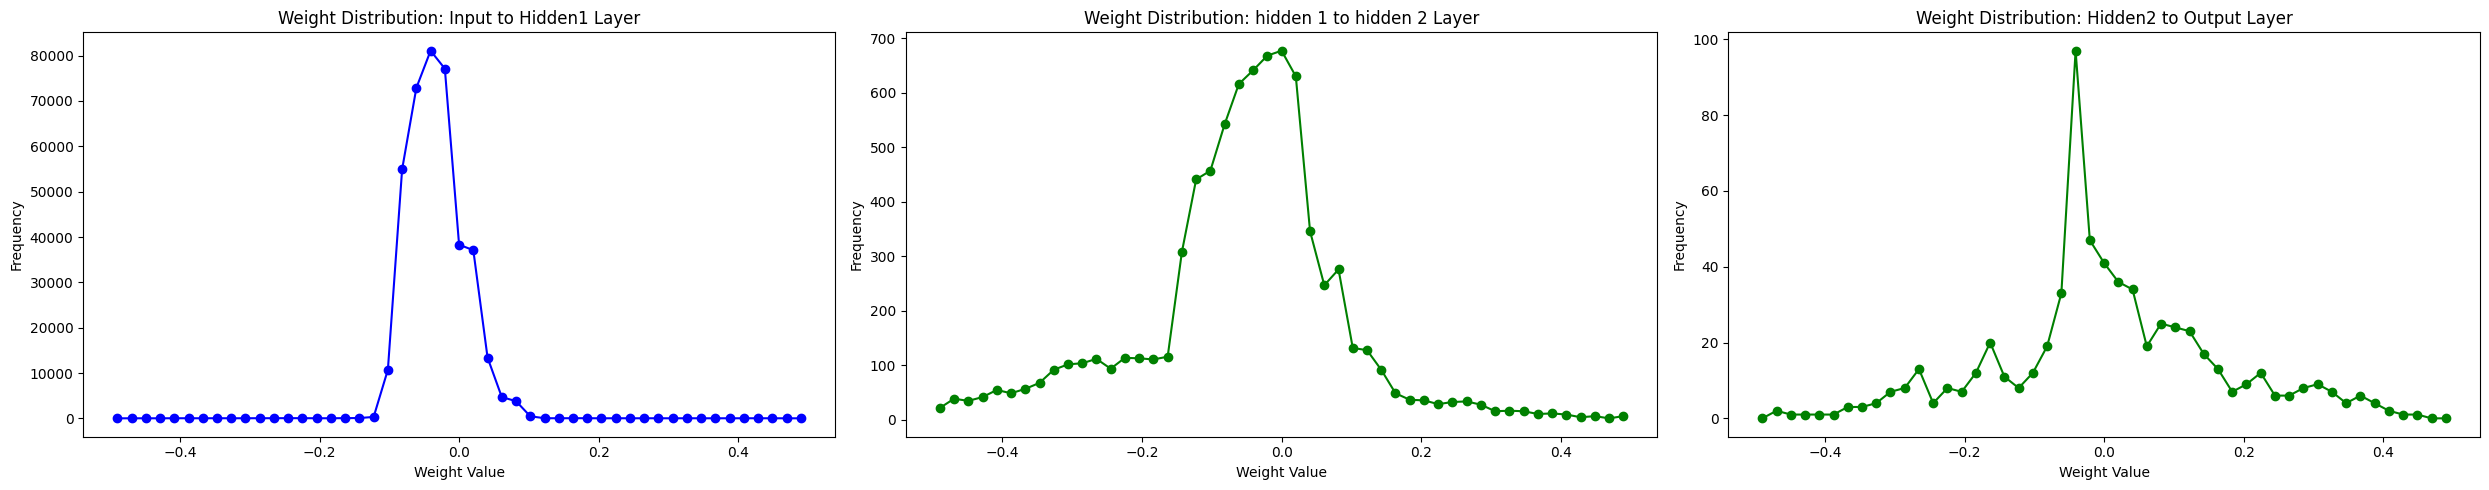

In [7]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [8]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 364053
Number of non-zero weights greater than 0.01 in layer 1: 7534
Number of non-zero weights greater than 0.01 in layer 3: 599


In [9]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.673019307634971, 0.7444903269946196, 0.7712721603146088, 0.6785834901856918, 0.633811157493597, 0.7410533957368448, 0.7663234130975418, 0.6830031696468474, 0.6799179561875545, 0.7013388943251231, 0.677128595823347, 0.6919857470677464, 0.7509077533814529, 0.8053593304256329, 0.6918406447617507, 0.7485484381531314, 0.7553491141901286, 0.7267541737782163, 0.6341312937373657, 0.7122704955286792, 0.6861299574798704, 0.6795257423158015, 0.6656314906217451, 0.6247665199150916, 0.6819428879421184, 0.6833442783965181, 0.6223315383807756, 0.6804397442998649, 0.6556474106988248, 0.7291670512225584, 0.7414026477300656, 0.7322703507987068, 0.7167734532167802, 0.7416496199358257, 0.6888143106187496, 0.694036225825422, 0.7177613436680436, 0.613305688172306, 0.6895909021982688, 0.6759559481011509, 0.6742940684638611, 0.6525844644553103, 0.8285126784913782, 0.6584048887877925, 0.7682748239066097, 0.6662851816099731, 0.6853569633992794, 0.6963569464252295, 0.7282560936210761, 0.650942498992104, 0.762

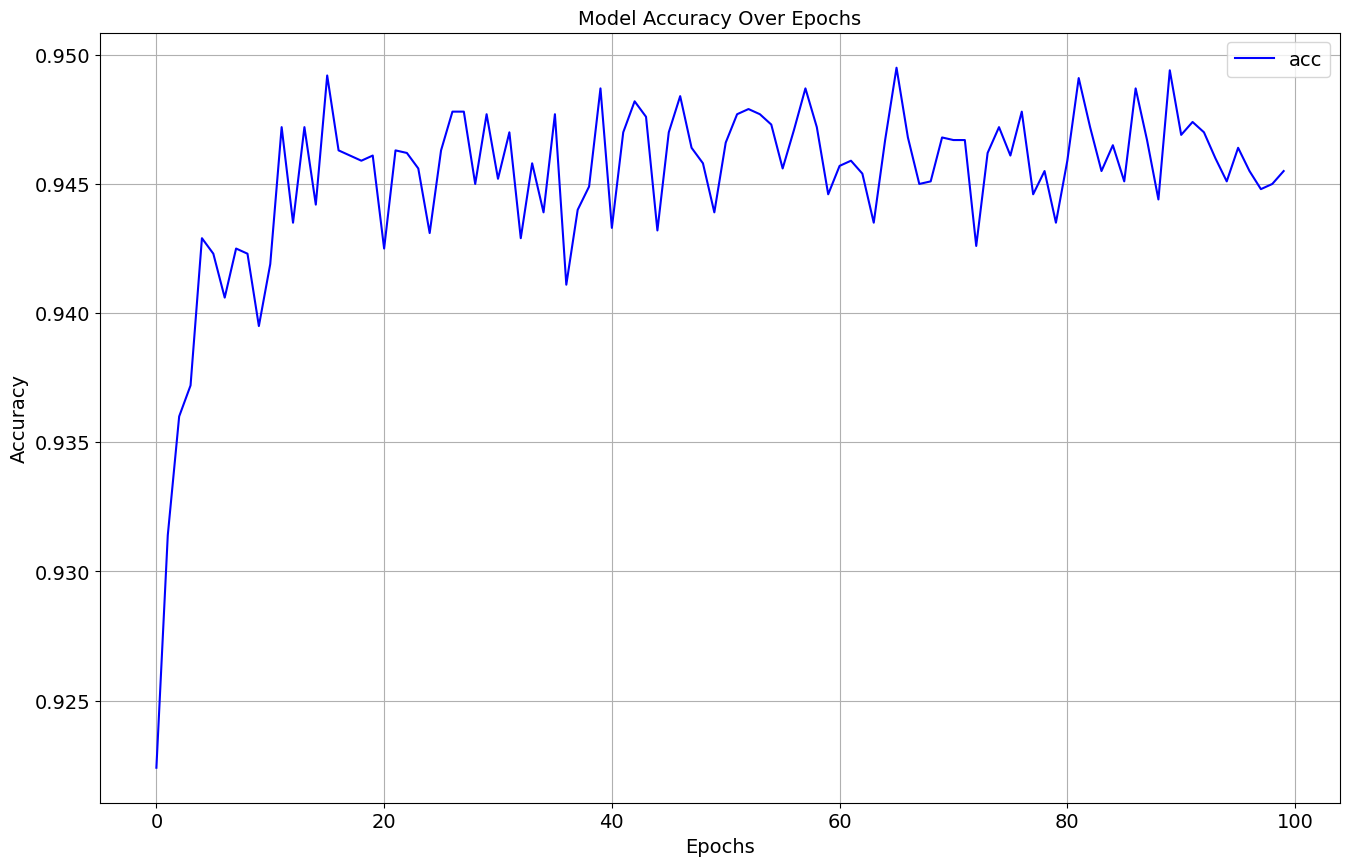

In [10]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [11]:
import pickle
with open('cleanAcc.pkl', 'wb') as f:
    pickle.dump(acc, f)